In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, accuracy_score

from mlxtend.plotting import plot_decision_regions
## pip install mlxtend
from sklearn.model_selection import cross_val_score
from sklearn import utils

import tensorflow as tf
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers


from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Dense
from keras.models import Sequential



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
# Merkmalsreduktion
# Schneide irrelevante Informationen aus dem Bilder heraus.
# Speichere die Merkalsreduzierten Bilder in einen neuen Ordner /data/

all_dogs = 0  # Zählvariable der Hundebilder 
data_dir = os.getcwd() + '\\'
breed_list = os.listdir(data_dir + 'images\\Images\\')
os.makedirs('data', exist_ok=True)


for breed in breed_list:
    os.makedirs('data\\' + breed, exist_ok=True)
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotation\\Annotation\\' + breed):
        img = Image.open(data_dir + 'images\\Images\\' + breed + '\\' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotation\\Annotation\\' + breed + '\\' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data//' + breed + '/' + file + '.jpg')
        all_dogs = all_dogs+1

In [3]:
#lese daten  in "bilder aka imagepath array ein und der dazugehörigen daten aka label_array"
# Speichere die Bilddaten (RGB Werte) in ein array
# Speichere die Hunderassen in 
SCALE = 128 # Setzte Skalierungsfaktor auf welchen die Bilder alle Skaliert werden
data_array = []
label_array= []
breedNum = 0
for breed in breed_list:
    imagepath=(data_dir + 'data\\' + breed )
    for img in os.listdir(imagepath):
        img_array=cv2.imread(os.path.join(imagepath,img))
        #data_array.append(img_array.tolist())
        data_array.append(cv2.resize(img_array,(SCALE,SCALE)).tolist())
        label_array.append(breedNum) # Setze Hunderasseart auf eine ID
    breedNum = breedNum + 1

In [4]:
#reshape und skaliere alle Bilder
data_array = np.array(data_array)
data_array = data_array.reshape(len(data_array), 3, SCALE, SCALE).transpose(0,2,3,1)

In [5]:
# Feature Extraktion 
data_features = []
for i in range(0, all_dogs):
    img = data_array[i]
    features = np.array([None] * 2)
    features[0] = np.mean(img[:, :, 0]) # Extrahiere average HUE Wert
    features[1] = np.mean(img[:, :, 1]) # Extrahiere Saturations Wert
    data_features.append(features.tolist()) 

# Mit dem MinMaxScaler verschlechtert sich die Model accuracy oder sie wird nur geringfügig verbessert
#scaler = MinMaxScaler() # normalisiert die Werte
#scaler.fit(data_features)

In [6]:

#### Schuffel einschalten###
label_array, data_features = utils.shuffle(label_array, data_features)

# Einteilen der TEST und TRAIN Daten
size_of_train= int(all_dogs*0.75)
size_of_test = int(all_dogs*0.25)

X_train_features = data_features[:size_of_train]
X_test_features = data_features[-size_of_test:]

Y_train_features = label_array[:size_of_train]
Y_test_features = label_array[-size_of_test:]

In [7]:
# Umbennenen der Hunderassen. (Scheide Ziffern weg) 
# Zu besseren Darstellung in den Legenden der folgenden Schaubilder
for i in range(0, len(breed_list)):
    ar = breed_list[i].split('-')
    breed_list[i] = ar[1]

In [8]:
# Create the SVM
svm = SVC(kernel='rbf', gamma='scale')

# Fit the data to the SVM classifier
svm = svm.fit(X_train_features, Y_train_features)

# Generate predictions
y_pred = svm.predict(X_test_features)

# Evaluate by means of accuracy
accuracy = accuracy_score(Y_test_features, y_pred)
print(f'Model accuracy: {accuracy}')

vscores = cross_val_score(svm, X_test_features, Y_test_features, cv=3)
print('\nCross-Validation-Score 3-fold')
print(vscores)

Model accuracy: 0.43661971830985913

Cross-Validation-Score 3-fold
[0.46478873 0.49295775 0.38028169]


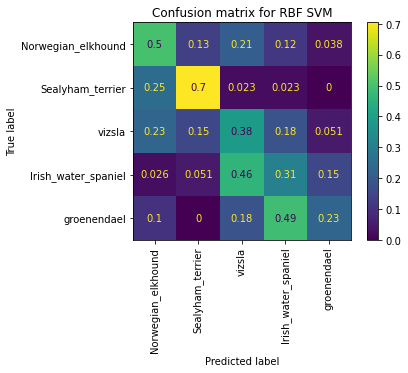

In [9]:
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm, X_test_features, Y_test_features,
                                 normalize='true',
                                 display_labels= breed_list
                                 )
plt.title('Confusion matrix for RBF SVM')
plt.xticks(rotation=90)

plt.show(matrix)
plt.show()


Decision boundary:


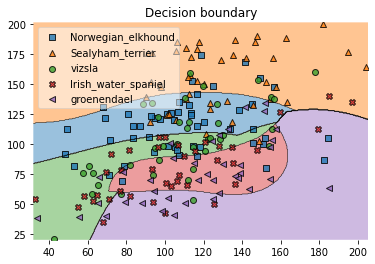

In [10]:
# Plot decision boundary
print('Decision boundary:')
ax = plot_decision_regions(np.array(X_test_features), np.array(Y_test_features), clf=svm, markers= "s^oX<")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          breed_list, 
          framealpha=0.5, 
          scatterpoints=1)

plt.title('Decision boundary')
plt.show()

In [11]:

#### Schuffel einschalten###
label_array, data_array = utils.shuffle(label_array, data_array)

# Einteilen der TEST und TRAIN Daten
size_of_train= int(all_dogs*0.75)
size_of_test = int(all_dogs*0.25)
X_train = np.array(data_array[:size_of_train])
Y_train = np.array(label_array[:size_of_train])

X_test = np.array(data_array[-size_of_test:])
Y_test = np.array(label_array[-size_of_test:])

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [12]:
input_shape = (SCALE, SCALE, 3)


X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_train=X_train / 255.0

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_test=X_test / 255.0


Y_train = tf.one_hot(Y_train.astype(np.int32), depth=10)
Y_test = tf.one_hot(Y_test.astype(np.int32), depth=10)


In [13]:
batch_size = 32
num_classes = 10
epochs = 20


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=X_train.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', input_shape=X_train.shape[1:], activation='relu'),
    #tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128, 3, padding='same', input_shape=X_train.shape[1:],  activation='relu'),
    #tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax'),

])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss='categorical_crossentropy', metrics=['acc'])

In [14]:
#history = model.fit(X_train, Y_train, batch_size=batch_size,
#                epochs=epochs)
print(X_train.shape)
print(Y_train.shape)
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          #shuffle=False,
          verbose=1)
          #validation_data=(X_test, Y_test))

(639, 128, 128, 3)
(639, 10)
Epoch 1/20
20/20 [==============================] - 10s 381ms/step - loss: 2.5746 - acc: 0.1862
Epoch 2/20
20/20 [==============================] - 8s 376ms/step - loss: 1.6745 - acc: 0.2207
Epoch 3/20
20/20 [==============================] - 7s 372ms/step - loss: 1.6463 - acc: 0.2254
Epoch 4/20
20/20 [==============================] - 8s 381ms/step - loss: 1.6655 - acc: 0.2207
Epoch 5/20
20/20 [==============================] - 7s 355ms/step - loss: 1.6265 - acc: 0.2097
Epoch 6/20
20/20 [==============================] - 7s 372ms/step - loss: 1.6389 - acc: 0.2707
Epoch 7/20
20/20 [==============================] - 8s 393ms/step - loss: 1.6098 - acc: 0.2488
Epoch 8/20
20/20 [==============================] - 8s 391ms/step - loss: 1.6220 - acc: 0.2379
Epoch 9/20
20/20 [==============================] - 8s 388ms/step - loss: 1.5979 - acc: 0.2817
Epoch 10/20
20/20 [==============================] - 7s 373ms/step - loss: 1.5744 - acc: 0.3067
Epoch 11/20
20/20 [

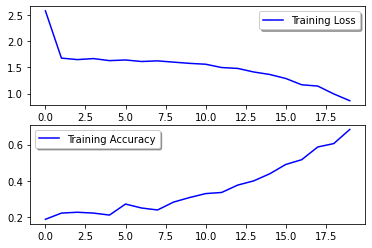

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.352464437484741
Test accuracy: 0.2065727710723877


In [19]:

scores = cross_val_score(model, X_test, Y_test, cv=3, scoring='accuracy')
print('\nCross-Validation-Score 3-fold')
print(scores)


TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x00000179D272F4C0>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Confusion Matrix
 X-Achse = Predicted Labeles Y-Achse = die wahren Labels 


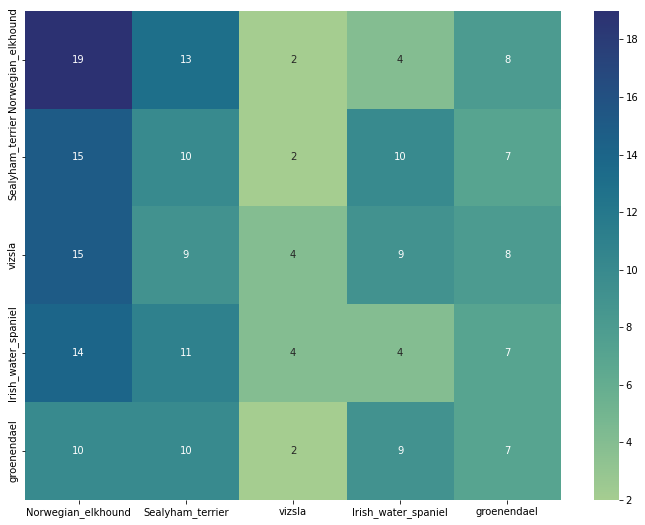

In [18]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test, verbose=0)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors

y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))

c = sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap="crest")
c.set(xticklabels=breed_list, yticklabels=breed_list)



print("Confusion Matrix")
print(" X-Achse = Predicted Labeles Y-Achse = die wahren Labels ")
